FTIR Peak Fitting for Bruker Hyperion 2000 FTIR Microscope (Also works for single spectra taken with Invenio)
put toghether by Jeff Roshko Summer 2022 to 2023

This notebook is based on a previously developed code demonstrating spectral deconvolution using the FTIR tool suite 
developed by KBI Biopharma. 

Instead of using full 9 peaks often used for silk fibroin secondary structure analysis, this script will use 4 "peaks" from
"Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system" 
by Mehtap Fevzioglu, Oguz Kaan Ozturk, Bruce R.Hamaker, Osvaldo H.Campanell 
Four "peaks" are:
 beta-sheet (low frequency)
 random structure & alpha helix
 beta-turn
 Beta sheet (high frequency)


The spectral deconvolution tools utilize the scipy solvers to deconvolute second derivative or fourier self deconvolution spectra 
using a guassian peak model. 

There are three parameters per peak (mean, height and width), and thus 36 inputs are present for a 12 peak reference set. 
The default peak definitions `yang_h20_2015` has 14 peaks, and thus 42 input parameters are present. 
The parameter space is very large, and thus different gradient based solvers are likely to converge to slightly different local minima. 
A least squares approach using a linear loss function `rho(z) = z` was used for decomposition


Jeff's list of potential improvements :
- Can consider applying FSD to spectra as I don't think this is being applied here before the least-squares fitting method
- May want to change "Append" in fitting section to "concat" based on using python 3.10 and trying to setup virtual env
-should using opusFC to incorporate x and y coordinates for each data point instead of merely making a grid

Jeff's Notable modifications:

Mar 20 2023: added user interface for heatmapping
Mar 23 2023: Added fancier looking spectra plots (filled in with color), 
- Added option to mention if there is a header in imported file

August 30th 2023: this is for analysis of time at 45C and 90%RH in humidity chamber, with timer starting only once chamber reaches 90%RH

In [1]:
import os
import sys
os.chdir(r'C:\Users\jrosh\Documents\FTIR_Mapping\ftir')
sys.path.append("../")

# imports
# import to take 2nd derivative as I don't think this occured, Jeff 2.28.2022
import numpy as np
import seaborn as sns
# added this to avoid additional layer of subplotting of residuals
from ftir.modeling.peak_fitting import create_fit_singleplot
from tkinter import filedialog
from tkinter import *
import tkinter as tk
import time
from scipy.spatial import ConvexHull
from scipy import optimize
import matplotlib.pyplot as plt
import math
from ftir.io.utils import create_df_from_single_file
from ftir.modeling.peak_fitting import secondary_structure, create_fit_plots, gaussian_list, sd_baseline_correction, gaussian_integral, gaussian_sum
from ftir.modeling.peak_fitting import gaussian_minimize, gaussian_differential_evolution, gaussian_least_squares
from ftir.modeling.buffer_subtraction import find_buffer_subtraction_constant, buffer_subtract
import ftir.modeling.peak_fitting as peak_fitting

import scipy
import pandas as pd

%matplotlib inline

# from ftir.modeling.peak_definitions import yang_h20_2015, dong_h2o_1990, yang_list
# import ftir.modeling.peak_definitions
#from ftir.modeling.peak_definitions import four_peak

Setup, Import Code

In [2]:
# import data file in csv format (modify for your file path/file name between the "" if you want to, leave blank for GUI option)
# Takes a csv file with first column being wavenumbers, 2nd and onward are relative intensity values, no headers

# #Manual Filename Entry, commented out and instead using GUI for now
# filenamevar = r"R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\InvenioATR1hr60C0hr3hr6hrUVtestCombinedNoLabel.csv"

filenamevar = r""
#rawData_df ="nil"
if bool(filenamevar):
    rawData_df = pd.read_csv(filenamevar, header=None)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)

    win.withdraw()  # prevents an empty tkinter window from appearing
    #top = Toplevel()

    def func():
        global filenamevar
        filenamevar = filedialog.askopenfilename(multiple=True, filetypes=[('DPT,CSV, or typeless OPUS files', '*.dpt *.csv .*'), ('CSV Files', '*.csv'), ('Typeless files from OPUS', '.*')],
                                                 parent=win,  title='Open a CSV file of Wavenumber (first column) and data points in subsequent columnns to analyze',
                                                 initialdir='R:\Jeff\FTIR\Structural Mapping\7.21.2022 22.5wt%120mb\CalibrationOf45cWAing')  # , header=1,)
        global rawData_df
        global wnrawData_df
        # print(filenamevar)
        # print(type(filenamevar))
        print(len(filenamevar))
        if len(filenamevar) > 1:
            print("multiple files, tuple")
            spectral_data = {}

            for file in filenamevar:
                if filenamevar[0].endswith('.csv'):
                    # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                    spectral_data[os.path.basename(file)] = pd.read_csv(
                        file, names=(["wavenumber", os.path.basename(file)]))
                elif filenamevar[0].endswith('.dpt'):
                    # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                    spectral_data[os.path.basename(file)] = pd.read_csv(
                        file, sep="\t",dtype=object, names=(["wavenumber", os.path.basename(file)]))
                else:
                    # commented 8/25 to revert back; header=1,names = (["wavenumber", os.path.basename(file)]))
                    spectral_data[os.path.basename(file)] = pd.read_csv(
                        file, sep="\t", names=(["wavenumber", os.path.basename(file)]))
            rawData_df = pd.DataFrame()
            for key, values in spectral_data.items():
                rawData_df['wavenumber'] = values['wavenumber']
                rawData_df[key] = values[key]
            wnrawData_df = rawData_df  # already has wavenumber in the first column header
        elif filenamevar[0].endswith('.csv'):
            print('single csv')
            rawData_df = pd.read_csv(filenamevar[0], header=1)
            # put wavenumber in the first column header
            dims = []
            for i in range(1, rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber']) + dims
            wnrawData_df = pd.DataFrame(
                rawData_df.values, columns=column_names)
        elif filenamevar[0].endswith('.dpt'):
            print('single dpt')
            # ,names = (["wavenumber",[1,]]))
            rawData_df = pd.read_csv(filenamevar[0], header=None, sep="\t")
            # put wavenumber in the first column header
            dims = []
            for i in range(1, rawData_df.shape[1]):
                dims.append(f"cols{i}")
            column_names = list(['wavenumber']) + dims
            wnrawData_df = pd.DataFrame(
                rawData_df.values, columns=column_names)
        # to do: add something here for single xy file output from OPUS:
        # else:
        #     rawData_df = pd.read_csv(filenamevar, header=None, sep = "\t") #,names = (["wavenumber",[1,]]))
        #     rawData_df
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy()

    func()
    # quit()

    win.mainloop()


entering GUI file input mode via Tkinter
48
multiple files, tuple


In [3]:
# set size of "image" with gui,
# asks if there is a row of labels (ie, if the first row is a header)

# Make a simple input for x and y dimensions of mapping
# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/
# Returns xvalue and yvalue globally
root = tk.Tk()

# setting the windows size
root.geometry("450x200")
root.eval('tk::PlaceWindow . center')
root.wm_attributes('-topmost', True)
# root.lift()

# declaring numerical variables for storing x and y values
x_var = tk.IntVar()
y_var = tk.IntVar()
header_var = tk.BooleanVar()

# defining a function that will get x and y values and close the window
def submit():
    global user_message_entry, num_in_x, num_in_y, contains_header
    # t = Toplevel(root)
    num_in_x = int(x_var.get())
    num_in_y = int(y_var.get())
    # contains_header = bool(header_var.get())
    contains_header = header_var.get()
    
    print("Total number of spectra: " + str(num_in_x*num_in_y))
    time.sleep(0.5)
    root.destroy()

# creating a label for x using widget Label
x_label = tk.Label(root, text='Number of mapping points in x : ',
                   font=('calibre', 10, 'bold'))

# creating a entry for input of x using widget Entry
x_entry = tk.Entry(root, textvariable=x_var, font=('calibre', 10, 'normal'))

# creating a label for y using widget Label
y_label = tk.Label(root, text='Number of mapping points in y : ',
                   font=('calibre', 10, 'bold'))

# creating a entry for y using widget Entry
y_entry = tk.Entry(root, textvariable=y_var, font=('calibre', 10, 'normal'))

# creating a label for header variable using widget Label
header_label = tk.Label(
    root, text='Is the first row a data header? : ', font=('calibre', 10, 'bold'))

# creating a entry for header variable using widget Entry
# header_entry=tk.Entry(root, textvariable = header_var, font = ('calibre',10,'normal'))
# make a drop down menu for header variable
header_var = tk.StringVar(root)
# header_var.set("True")  # default value
header_entry = tk.OptionMenu(root, header_var, "True", "False")

# creating a button using the widget button that will call the submit function
sub_btn = tk.Button(root, text='Submit',
                    command=lambda: submit(), height=4, width=15)

# placing the label and entry in the required position using grid method
x_label.grid(row=0, column=0)
x_entry.grid(row=0, column=1)
y_label.grid(row=1, column=0)
y_entry.grid(row=1, column=1)
header_entry.grid(row=2, column=1)
header_label.grid(row=2, column=0)
# make submit button centered in the windw
# sub_btn.grid(row=3,column=1)
sub_btn.place(x=175, y=100)

# performing an infinite loop for the window to display
root.mainloop()

Total number of spectra: 48


In [4]:
# GUI to prompt user for directory to save spectra, 1-d data, heatmap, or csv of data with statistical analysis
import tkinter as tk
from tkinter import *
from tkinter import filedialog

savefolderpath = r""
#rawData_df ="nil"
if bool(savefolderpath):
    rawData_df = pd.read_csv(savefolderpath, dtype=object, index = False)
else:
    print('entering GUI file input mode via Tkinter')
    win = Tk()
    win.wm_attributes('-topmost', 1)

    win.withdraw()  # prevents an empty tkinter window from appearing
    #top = Toplevel()

    def func():
        global savefolderpath
        savefolderpath = filedialog.askdirectory(parent=win, title='Select a folder wherein your results will be saved',
                                                 initialdir=os.path.dirname(os.path.dirname(filenamevar[0])))  # , header=1,)
        # global rawData_df
        # rawData_df = pd.read_csv(filenamevar, header=None)
        print(savefolderpath)
        win.wm_attributes('-topmost', False)
        win.destroy()

    def quit():
        win.destroy()

    func()
    win.mainloop()

entering GUI file input mode via Tkinter
C:/Users/jrosh/Box/FTIR/2023.08.30 Calibrating Oven for SteamMasking with Nick/Output


In [4]:
# # Name the data columns

# #Add a number after repeated header values to make them unique
# # https://stackoverflow.com/questions/20250771/remap-columns-names-in-pandas

# wnrawData_df.columns = [["wavenumber"]+ 27*["layers_16"]+ 27*["layers_8"]+27*["layers_4"]+ 27*["layers_2"]
# +27*["layers_1"]+(len(wnrawData_df.columns)-(27*5)-1)*["control"]]

# class renamer():
#     def __init__(self):
#         self.d = dict()

#     def __call__(self, x):
#         if x not in self.d:
#             self.d[x] = 0
#             if x == "wavenumber":
#                 return x
#             else:
#                 return "%s_%d" % (x, self.d[x])
#         else:
#             self.d[x] += 1
#             return "%s_%d" % (x, self.d[x])

# wnrawData_df.rename(columns=renamer(), inplace=True)


# # wnrawData_sansHead_df.columns = [["Wavenumber"]+ 27*["16L"]+ 27*["8L"]+27*["4L"]+ 27*["2L"]
# # +27*["1L"]+(len(wnrawData_sansHead_df.columns)-(27*5)-1)*["Control"]]

# # class renamer():
# #     def __init__(self):
# #         self.d = dict()

# #     def __call__(self, x):
# #         if x not in self.d:
# #             self.d[x] = 0
# #             return x
# #         else:
# #             self.d[x] += 1
# #             return "%s_%d" % (x, self.d[x])

# # wnrawData_sansHead_df.rename(columns=renamer())

# #Testing list  for renaming columns
# # ["Wavenumber"]+ 27*["16L"]+ 27*["8L"]+27*["4L"]+ 27*["2L"]
# # +27*["1L"]+(len(wnrawData_sansHead_df.columns)-(27*5)-1)*["Control"]

# # #len(wnrawData_sansHead_df.columns)


## Baseline correction

Rubberband baseline correction, flipping the spectra over the y-axis, and narrowing focus only on the amide I region.(Do we need to normalize to 1?)

In [5]:
# only show between 1715 and 1595
baseline_corrected_AmideI = []
# for cols_ in beta_sheet_df.columns[1:]:
#     #print(str(cols_))
#     baseline_corrected_AmideI.append(sd_baseline_correction(beta_sheet_df, cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
if contains_header==True:
    print(1)
    for cols_ in wnrawData_df.columns[1:]:
        # select data from columns start after the header
        wnrawData_sansHead_df = wnrawData_df
        # header_row = 0
        # wnrawData_sansHead_df.columns = wnrawData_sansHead_df.iloc[header_row]
        wnrawData_sansHead_df = wnrawData_sansHead_df.iloc[1:].astype(float)
        # print(wnrawData_sansHead_df)
        baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_sansHead_df, 
                            cols=[cols_], flip=False, method='rubberband', bounds=(1715, 1595)))
else:
    print(2)
    for cols_ in wnrawData_df.columns[1:]:
        baseline_corrected_AmideI.append(sd_baseline_correction(wnrawData_df, cols=[
                                         cols_], flip=False, method='rubberband', bounds=(1715, 1595)))

2


In [6]:
# baseline_corrected_AmideI

Normalize list (min-max)

In [7]:
normalized_baseline_AmideI = baseline_corrected_AmideI
i = 0
for list_ in baseline_corrected_AmideI:
    normalized_baseline_AmideI[i][list_.columns[1]] = (list_[list_.columns[1]]-list_[
                                                       list_.columns[1]].min())/(list_[list_.columns[1]].max()-list_[list_.columns[1]].min())
    i += 1

In [8]:
normalized_baseline_AmideI

[    wavenumber  0min_control.0
 0   1713.64989        0.000000
 1   1712.22185        0.001397
 2   1710.79381        0.003516
 3   1709.36577        0.006397
 4   1707.93772        0.010998
 ..         ...             ...
 79  1600.83461        0.057961
 80  1599.40657        0.041223
 81  1597.97852        0.026881
 82  1596.55048        0.013409
 83  1595.12244        0.000000
 
 [84 rows x 2 columns],
     wavenumber  0min_control.1
 0   1713.64989        0.000000
 1   1712.22185        0.001364
 2   1710.79381        0.003470
 3   1709.36577        0.006382
 4   1707.93772        0.011056
 ..         ...             ...
 79  1600.83461        0.058116
 80  1599.40657        0.041316
 81  1597.97852        0.026894
 82  1596.55048        0.013383
 83  1595.12244        0.000000
 
 [84 rows x 2 columns],
     wavenumber  0min_control.2
 0   1713.64989        0.000000
 1   1712.22185        0.001420
 2   1710.79381        0.003671
 3   1709.36577        0.006799
 4   1707.93772     

## Peak settings for peak fitting

In [9]:
four_peak = {
    'means': [1620,  1636, 1679, 1700],
    # 'means': [1627,  1650, 1679,1700],

    'uncertainties': [(1613, 1626), (1627, 1664), (1668, 1685), (1697, 1703)],
    # 'uncertainties': [(1613, 1632), (1640, 1657), (1668, 1685), (1697, 1703)],
    # 'relative_uncertainties': [10, 12, 16,3],
    # 'relative_uncertainties': [2, 2, 1,2],
    'assignments': ['aggregate \u03B2-strand/\u03B2-sheet',
                    'random coils + \u03B1 helices', '\u03B2-turns', 'intermolecular \u03B2-sheets (weak)']}

###Plotting spectra and their invidual fits

In [10]:
# Jeff 8/25/2022: attempt to redo this portion more simply. Import it as is, and if the file is an image from the microscope (multiple spectra in one file), then flip it
from matplotlib.offsetbox import AnchoredText
plt.ioff()
#reluncert = 5

#  Approach: make a grid as it is pulled from non-flattened indices so that I can more easily think about the math for propper placement of "pixels";  subplots in python normally start at top left, but
# should actually start at bottom left for opus ftir microscope files. Possibly put another gui to allow users to select which corner data collection starts in/ ]
# ultimate goal is to directly extract data with (x,y) pixel location from opus files and avoid this issue completely

pw = 30  # peak width 30cm^-1 from "Quantitative approach to study secondary structure of proteins by FT-IR spectroscopy, using a model wheat gluten system"
gainnum = 0.95  # gain; was originally 0.95
peakfitlibname = 'four_peak'
peaksfittinglib = four_peak
print(peaksfittinglib)

rearranged_CB_color_cycle = ['#377eb8', '#4daf4a', '#ff7f00',  '#377eb8'] # RC/helix, beta turn, then beta sheet

if (num_in_x<15) and (num_in_y<15):
    print('high res')
    fig, axs = plt.subplots(num_in_y, num_in_x, figsize=(num_in_x*8.5, num_in_y*5), dpi=200)
else:
    print('low res')
    fig, axs = plt.subplots(num_in_y, num_in_x, figsize=(num_in_x*1.2, num_in_y*1), dpi=50)

titletext = ('Peak Fitting Parameters' + '\n' + 'Peak Means:' + str(peaksfittinglib['means']) + "\n" + 'Uncertainties: ' + str(peaksfittinglib['uncertainties']) +
             "\n" + 'Starting Peak Intensity (gain): ' + str(gainnum) + ', Peak Width: ' + str(pw))
fig.suptitle(titletext, fontsize=18, y=1.1, va='top')
fig.subplots_adjust(hspace=.3, wspace=.3)
plt.figure(facecolor='white')
fig.patch.set_facecolor('white')

structs = []
gaussian_data = []
secondary_structs_df = pd.DataFrame()
dashlist = ['--', '--', '--', '-.']

# if grid_layout == True: 
for j in range(0, num_in_y):
    for i in range(0, num_in_x):
        #August 31 2023: added if statement to discern between multiple file uploads vs one file with multiple datapoints as I think the ordermight be getting messed up here
        if len(filenamevar) > 1:
            indexnum = i+j*(num_in_x)
        else:
            indexnum = (num_in_x)*(num_in_y-(j+1))+i # this should convert current index to the correct index from the original "linear" dataset for plotting purposes since the data point table doesn't have any location information
        
        sample = baseline_corrected_AmideI[indexnum].columns[1] #actual data from sample (not the wavenumber)
        area, res = gaussian_least_squares(baseline_corrected_AmideI[indexnum], sample, peak_width=pw,peaks=peaksfittinglib, params={'loss': 'linear'})
        structs.append(secondary_structure(area, peaksfittinglib)) # secondary_structure() returns dict-> ### At some point, I should make this into a single dataframe###
        gaussian_list_data = gaussian_list(baseline_corrected_AmideI[indexnum]['wavenumber'], *res.x)
        gaussian_data.append(gaussian_list_data)
        secondary_structs_df.append(pd.DataFrame.from_dict(structs, orient='columns'))
        # does this math work for crawling through the numbers? maybe this is where I need to apply the logic and put the right data in the right place?
        xdata = baseline_corrected_AmideI[indexnum].iloc[:, 0]
        y_fit = sum(gaussian_list_data)
        # probably should have just done this normally and then transposed/flipped the data frame. Maybe next time
        # index is a bit whack here, need to start from bottom left and starts from top left
        # need to modify for running a series of data not from mapping, or running a line (in which case one of the two dimensions are ==1)
        if (num_in_y == 1) or (num_in_x == 1):
            # need to modify this still to work if it's a y-direction sinle line (just need to change index somehow with j and i maybe?)
            # Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[i].plot(xdata, baseline_corrected_AmideI[i]
                        [sample], label='Baseline Corrected')
            axs[i].plot(xdata, y_fit, label='Model fit', ls='-.', linewidth=1)
            
            # calculate RSS for each spectrum - want to minimize this, might need to run some algorithm to do this 
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            rss = sum(resid*resid)

        # Label each of the gaussian curves with the correct type of peak
            for k in range(0, len(gaussian_list_data)):
                axs[i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls=dashlist[k],
                            label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k]), alpha=0.6, color=rearranged_CB_color_cycle[k])  # label=str(structs[j][1])) #label='')
            axs[i].invert_xaxis()

            legend1 = axs[i].legend(
                loc="upper left", fontsize='small', frameon=True)
            legend1.get_frame().set_edgecolor('b')
            rssTitle = "RSS: " + str("{:.1e}".format(rss))
            rssText = AnchoredText(rssTitle, loc='upper right', prop=dict(
                size=8), frameon=True, bbox_to_anchor=(1., 0.8), bbox_transform=axs[i].transAxes)
            ratioText = ('\u03B2-Sheet:' + str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) + '\n' + '\u03B1-Helix/' + '\n' + 'Random Coil:' 
                + str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'])) +
                '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'])))
            axs[i].add_artist(rssText)
            aRatioText = AnchoredText(
                ratioText, loc='upper right', prop=dict(size=8), frameon=True)
            axs[i].add_artist(aRatioText)
            
            strindexnum = str(sample) #strindexnum= str(indexnum), can also use #strindexnum = strindexnum.split('.')[0], depends on how you want to split
            
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')

            #numberinlist = AnchoredText(strindexnum, loc='upper center', prop=dict(size=7),frameon=False)
            # axs[i].add_artist(numberinlist)
            axs[i].set_title(strindexnum)
        else:
            axs[j, i].plot(xdata, baseline_corrected_AmideI[indexnum][sample],
                        label='Baseline Corrected', color='black', linewidth=0.75) # Jeff changed this to 'Baseline Corrected' from '$2^{nd}$ derivative' on 3.23.2022
            axs[j, i].plot(xdata, y_fit, label='Model fit',ls='--', linewidth=1, color='grey')
            # calculate RSS for each spectrum, want to minimize this, might need to run some algorithm to do this
            resid = baseline_corrected_AmideI[indexnum][sample] - y_fit
            rss = sum(resid*resid) 
            #Label each of the gaussian curves with the correct type of peak
            for k in range(len(gaussian_list_data)):
                axs[j, i].plot(xdata, gaussian_list_data[len(peaksfittinglib['means'])-1-k], ls=dashlist[k],  # ls='--',
                            label=str(peaksfittinglib['assignments'][len(peaksfittinglib['means'])-1-k]), color=rearranged_CB_color_cycle[k])  # label=str(structs[j][1])) #label='')
                axs[j, i].fill_between(xdata, gaussian_list_data[len(
                    peaksfittinglib['means'])-1-k], alpha=0.6, color=rearranged_CB_color_cycle[k])
            axs[j, i].invert_xaxis()

            legend1 = axs[j, i].legend(loc="upper left", fontsize='xx-small')
            legend1.get_frame().set_edgecolor('k')
            ratioText = ('\u03B2-Sheet:' + str("{:.0%}".format(structs[num_in_x*j+i]['aggregate \u03B2-strand/\u03B2-sheet'] +
                                                            structs[num_in_x*j+i]['intermolecular \u03B2-sheets (weak)'])) + '\n' + '\u03B1-Helix/'+'\n' + 'Random Coil:' + str("{:.0%}".format(structs[num_in_x*j+i]['random coils + \u03B1 helices'])) +
                        '\n'+'\u03B2-turns:' + str("{:.0%}".format(structs[num_in_x*j+i]['\u03B2-turns'])) + '\n' + 'RSS:' + str("{:.1e}".format(rss)))
            aRatioText = AnchoredText(
                ratioText, loc='upper right', prop=dict(size=6), frameon=False)
            axs[j, i].add_artist(aRatioText)
            strindexnum = str(sample) #strindexnum= str(indexnum)
            numberinlist = AnchoredText(
                strindexnum, loc='upper right', prop=dict(size=6), frameon=False)
            plt.setp(axs[:], ylabel='Arbitrary Absorbance Units')
            plt.setp(axs[:], xlabel=r'$Wavenumber (cm^{-1})$')
            # axs[j,i].add_artist(numberinlist)
            axs[j, i].set_title(strindexnum)
plt.gcf()
fullfigname = (savefolderpath+'/'+'spectra.png')
fullfignamesvg = (savefolderpath+'/'+'spectra.svg')
fig.savefig(fullfigname, dpi=300)
fig.savefig(fullfignamesvg, format="svg")
plt.close(fig)

{'means': [1620, 1636, 1679, 1700], 'uncertainties': [(1613, 1626), (1627, 1664), (1668, 1685), (1697, 1703)], 'assignments': ['aggregate β-strand/β-sheet', 'random coils + α helices', 'β-turns', 'intermolecular β-sheets (weak)']}
high res


In [12]:
# #Label each point with the correct name/add a number after repeated header values to make them unique
# # https://stackoverflow.com/questions/20250771/remap-columns-names-in-pandas
# labeled_data_df = wnrawData_df
# labeled_data_df.columns = ["wavenumber"]+ 27*["layers_16"]+ 27*["layers_8"]+27*["layers_4"]+ 27*["layers_2"]+27*["layers_1"]+(len(wnrawData_df.columns)-(27*5)-1)*["control"]

# class renamer():
#     def __init__(self):
#         self.d = dict()

#     def __call__(self, x):
#         if x not in self.d:
#             self.d[x] = 0
#             if x == "wavenumber":
#                 return x
#             else:
#                 return "%s_%d" % (x, self.d[x])
#         else:
#             self.d[x] += 1
#             return "%s_%d" % (x, self.d[x])

# labeled_data_df.rename(columns=renamer(), inplace=True)
# labeled_data_df

#Compare % of beta sheet via Seaborn Heatmap#

In [11]:
total_beta_percent = []
for i in range(0, len(structs)):
    total_beta_percent.append(
        structs[i]['aggregate \u03B2-strand/\u03B2-sheet'] + structs[i]['intermolecular \u03B2-sheets (weak)'])
# also make a new dataframe for math later
#total_beta_percent_df = pd.DataFrame(columns = total_beta_percent)

#print('total beta %', total_beta_percent)

# make two DFs, one with all secondary structure values, and then another one with total beta sheet only
secondary_structs_df = pd.DataFrame.from_dict(structs, orient='columns')  # columns=rawData_df[2:].columns)
secondary_structs_df = secondary_structs_df.transpose()
secondary_structs_df.columns = rawData_df.columns[1:]


total_beta_sheet_df = pd.DataFrame(
    total_beta_percent, columns=['TotalBetaSheet%'])
#total_beta_sheet_df.index = rawData_df.columns[0:]
#rawData_df.columns[0] = rawData_df.columns['fileheader','total beta_sheet %']

# extractedtime = []
# extractedsamplenumber = []
# for i in range(len(rawData_df.columns[1:])):
#     splitname = rawData_df.columns[1:][i].split("min")
#     extractedtime.append(int(splitname[0]))
#     splitname2 = rawData_df.columns[1:][i].split(".")
#     extractedsamplenumber.append(splitname2[1])
# print(extractedtime)

# total_beta_sheet_df['Minutes'] = extractedtime
# total_beta_sheet_df['SampleNumber'] = extractedsamplenumber
# total_beta_sheet_df = total_beta_sheet_df[['Minutes','SampleNumber','TotalBetaSheet%']]


# print(total_beta_sheet_df)
# #print(total_beta_sheet_df['1hr.0'])
# #print(total_beta_sheet_df['1hr.0']+total_beta_sheet_df['1hr.1'])

# #total_beta_sheet_df[total_beta_sheet_df['Minutes']==5]['TotalBetaSheet%']
# total_beta_sheet_df['TotalBetaSheet%'].plot()

In [12]:
pd.DataFrame.from_dict(structs, orient='columns').T

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
β-turns,2.211364e-01,2.219406e-01,0.193572,2.225088e-01,2.224284e-01,0.196293,0.193542,0.199177,0.205172,0.203923,...,0.143874,0.161077,0.151833,0.160142,0.138360,0.137988,0.145103,0.145449,0.146785,0.150573
aggregate β-strand/β-sheet,1.696702e-01,1.670707e-01,0.187016,1.650488e-01,1.646966e-01,0.183531,0.167002,0.166104,0.149203,0.150014,...,0.278680,0.263203,0.263312,0.260984,0.291390,0.290613,0.289263,0.281242,0.281491,0.281579
random coils + α helices,6.091934e-01,6.109887e-01,0.613249,6.124424e-01,6.128750e-01,0.614041,0.633358,0.628694,0.639368,0.639796,...,0.566815,0.565565,0.574622,0.568988,0.559346,0.560327,0.555073,0.562218,0.560834,0.557136
intermolecular β-sheets (weak),8.343035e-13,1.206594e-13,0.006163,1.213957e-13,4.239542e-13,0.006135,0.006098,0.006026,0.006257,0.006266,...,0.010631,0.010155,0.010233,0.009886,0.010903,0.011072,0.010560,0.011090,0.010889,0.010712


In [13]:
# labeled_secondary_structs_df = secondary_structs_df
# labeled_secondary_structs_df.columns = 27*["layers_16"]+ 27*["layers_8"]+27*["layers_4"]+ 27*["layers_2"]+36*["layers_1"]+(len(secondary_structs_df.columns)-(27*4+36))*["control"]

# class renamer():
#     def __init__(self):
#         self.d = dict()

#     def __call__(self, x):
#         if x not in self.d:
#             self.d[x] = 0
#             if x == "wavenumber":
#                 return x
#             else:
#                 return "%s_%d" % (x, self.d[x])
#         else:
#             self.d[x] += 1
#             return "%s_%d" % (x, self.d[x])

# labeled_secondary_structs_df.rename(columns=renamer(), inplace=True)

# labeled_secondary_structs_df  

In [14]:
shortenedhead_secondary_structs_df = secondary_structs_df

headers = shortenedhead_secondary_structs_df.columns
headers = headers.str.replace('_.*', '')

# Set the new column names
shortenedhead_secondary_structs_df.columns = headers

C:\Users\jrosh\AppData\Local\Temp/ipykernel_2180/3676066360.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  headers = headers.str.replace('_.*', '')


In [15]:
totalbetasavename = (savefolderpath+'/'+'1D_Total_beta_sheet.csv')
total_beta_sheet_df.to_csv(totalbetasavename, index=False)
#total_beta_sheet_df.to_csv("1D_Total_beta_sheet.csv", index = False)
total_beta_sheet_df

secondary_struct_savename = (savefolderpath+'/'+'labeled_secondary_structure.csv')
shortenedhead_secondary_structs_df.to_csv(secondary_struct_savename, index=True)

In [16]:
# Split up points into x by y grid
break_total_beta_percent = np.array_split(np.array(total_beta_percent), num_in_y)

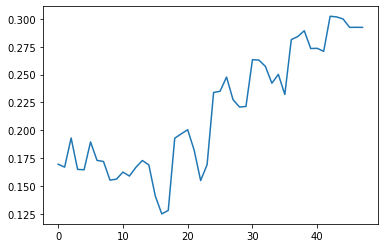

In [17]:
# 2D plot just in case it's useful
plt.plot(total_beta_percent)
fullfigname = (savefolderpath+'/'+'1-D.png')
plt.savefig(fullfigname)
plt.show()

In [20]:
# #for remembering what used to be and no longer is; spring cleaning from 60% IPA dataset
# cleaned_labeled_secondary_structs_df.drop(columns=['layers_4_14'], inplace=True)
# cleaned_labeled_secondary_structs_df.drop(columns=['layers_1_9','layers_1_10','layers_1_11','layers_1_12','layers_1_13','layers_1_14','layers_1_15','layers_1_16','layers_1_17'], inplace=True)
# cleaned_labeled_secondary_structs_df.drop(cleaned_labeled_secondary_structs_df['layers_2_15','layers_2_16','layers_2_17']) 

In [21]:
#Checking out the data visually for outliers
# plt.figure(figsize=(100,20))

# plt.plot(cleaned_labeled_secondary_structs_df.loc['aggregate β-strand/β-sheet'].iloc[50:70])
# #change text size of x axis
# plt.xticks(fontsize=25)

# plt.show()

# Stats!!!!!!!!!

In [18]:
cleaned_secondarystructs_df = shortenedhead_secondary_structs_df
#add a row in cleaned_secondarystructs_df that contains the portion of the header before the last _# (i.e. layers_1_9 becomes layers_1)
cleaned_secondarystructs_df.loc['minutes'] = cleaned_secondarystructs_df.columns.str.split('min').str[0]
cleaned_secondarystructs_df

# for cols in cleaned_secondarystructs_df.columns:
#     if 'control' in cols:
#         cleaned_secondarystructs_df[cols].loc['layers'] = '0'

cleaned_secondarystructs_df.loc['minutes'] = cleaned_secondarystructs_df.loc['minutes'].replace({'pt':'.'})        

#Add combined 'aggregate β-strand/β-sheet' and 'intermolecular β-sheet' row
cleaned_secondarystructs_df.loc['Total β-sheet content'] = cleaned_secondarystructs_df.loc['aggregate β-strand/β-sheet'] + cleaned_secondarystructs_df.loc['intermolecular β-sheets (weak)'] 

In [19]:
cleaned_secondarystructs_df.loc['minutes'] = cleaned_secondarystructs_df.loc['minutes'].str.replace('pt', '.')
cleaned_secondarystructs_df

,0min,0min,0min,0min,0min,0min,2min,2min,2min,2min,...,4pt75min,4pt75min,4pt75min,4pt75min,5min,5min,5min,5min,5min,5min
β-turns,0.221136,0.221941,0.193572,0.222509,0.222428,0.196293,0.193542,0.199177,0.205172,0.203923,...,0.143874,0.161077,0.151833,0.160142,0.13836,0.137988,0.145103,0.145449,0.146785,0.150573
aggregate β-strand/β-sheet,0.16967,0.167071,0.187016,0.165049,0.164697,0.183531,0.167002,0.166104,0.149203,0.150014,...,0.27868,0.263203,0.263312,0.260984,0.29139,0.290613,0.289263,0.281242,0.281491,0.281579
random coils + α helices,0.609193,0.610989,0.613249,0.612442,0.612875,0.614041,0.633358,0.628694,0.639368,0.639796,...,0.566815,0.565565,0.574622,0.568988,0.559346,0.560327,0.555073,0.562218,0.560834,0.557136
intermolecular β-sheets (weak),0.0,0.0,0.006163,0.0,0.0,0.006135,0.006098,0.006026,0.006257,0.006266,...,0.010631,0.010155,0.010233,0.009886,0.010903,0.011072,0.01056,0.01109,0.010889,0.010712
minutes,0,0,0,0,0,0,2,2,2,2,...,4.75,4.75,4.75,4.75,5,5,5,5,5,5
Total β-sheet content,0.16967,0.167071,0.19318,0.165049,0.164697,0.189666,0.1731,0.172129,0.15546,0.15628,...,0.289311,0.273358,0.273545,0.27087,0.302293,0.301685,0.299823,0.292333,0.29238,0.292291


In [20]:
# type(cleaned_secondarystructs_df.loc[cleaned_secondarystructs_df['layers']=='0', 'Total β-sheet content'][1])
# cleaned_secondarystructs_df[] = cleaned_secondarystructs_df.convert_objects(convert_numeric=True)

In [21]:
# cleaned_secondarystructs_df['layers'] = cleaned_secondarystructs_df['layers'].convert_objects(convert_numeric=True)

In [22]:
# annot.reset_configuration()
# subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
# subcat_order = ['0','1','2', '4', '8', '16']

# plotting = {
#     'data':    cleaned_secondarystructs_df,
#     'x':       'layers',
#     'y':       'Total β-sheet content',
#     'order':   subcat_order,
#     'palette': subcat_palette,
# }

# # pairs = [('0', '1'),
# #          ('0', '8'),
# #          ('4', '8')]

# #formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

# ax = sns.boxplot(**plotting)
# annot.new_plot(ax, **plotting)
# annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2,comparisons_correction="Bonferroni")
# test_results = annot.apply_test().annotate()

In [23]:
# import seaborn as sns

# from statannotations.Annotator import Annotator

# df = cleaned_secondarystructs_df
# x = "layers"
# y = "Total β-sheet content"
# order = ['0', '1', '2', '4', '8', '16']

# ax = sns.boxplot(data=df, x=x, y=y, order=order)

# pairs=[("0","1")]#, ("Thur", "Sat"), ("Fri", "Sun")]

# annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order)
# annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
# annotator.apply_and_annotate()
# plt.show()

cleaning bad data points if necessary


In [24]:
# #Testing Normality of each group
# totalbeta_df = pd.concat(cleaned_secondarystructs_df['layers'],cleaned_secondarystructs_df['Total β-sheet content'])#.loc[(cleaned_secondarystructs_df.layers =='Technology'), :]
# rfs = tech.loc[(tech.Subcategory.isin(("Robots", "Flight", "Sound"))), :]

# zero = rfs.loc[(rfs.Layers == "0"), "Total β-sheet content"].values
# one = rfs.loc[(rfs.Subcategory == "Flight"), "Goal"].values
# two = rfs.loc[(rfs.Subcategory == "Sound"), "Goal"].values


# log_robots = np.log(robots)
# log_flight = np.log(flight)
# log_sound = np.log(sound)


# print("0: ", normaltest(cleaned_secondarystructs_df.loc[cleaned_secondarystructs_df['layers']=='0', 'Total β-sheet content']).pvalue)
# print("1: ", normaltest(flight).pvalue)
# print("2: ", normaltest(sound).pvalue)
# print("4: ", normaltest(robots).pvalue)
# print("8: ", normaltest(flight).pvalue)
# print("16: ", normaltest(sound).pvalue)
# print()
# print("Log(robots): ", normaltest(log_robots).pvalue)
# print("Log(Flight): ", normaltest(log_flight).pvalue)
# print("Log(Sound): ", normaltest(log_sound).pvalue)

In [25]:
# cleaned_secondarystructs_df.to_csv(savefolderpath+'/' +'70wt%IPA_1D_secondary_structs_CLEANED.csv')#, index=False)

0 vs. 2: Welch's t-test independent samples with Bonferroni correction, P_val:6.456e-01 t=1.906e+00
2 vs. 3: Welch's t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.333e+00
3 vs. 3.5: Welch's t-test independent samples with Bonferroni correction, P_val:1.307e-01 t=-2.825e+00
3.5 vs. 4: Welch's t-test independent samples with Bonferroni correction, P_val:2.931e-03 t=-5.794e+00
4 vs. 4.5: Welch's t-test independent samples with Bonferroni correction, P_val:8.165e-02 t=-3.105e+00
4.5 vs. 4.75: Welch's t-test independent samples with Bonferroni correction, P_val:1.096e-02 t=-4.665e+00
4.75 vs. 5: Welch's t-test independent samples with Bonferroni correction, P_val:5.373e-03 t=-5.017e+00


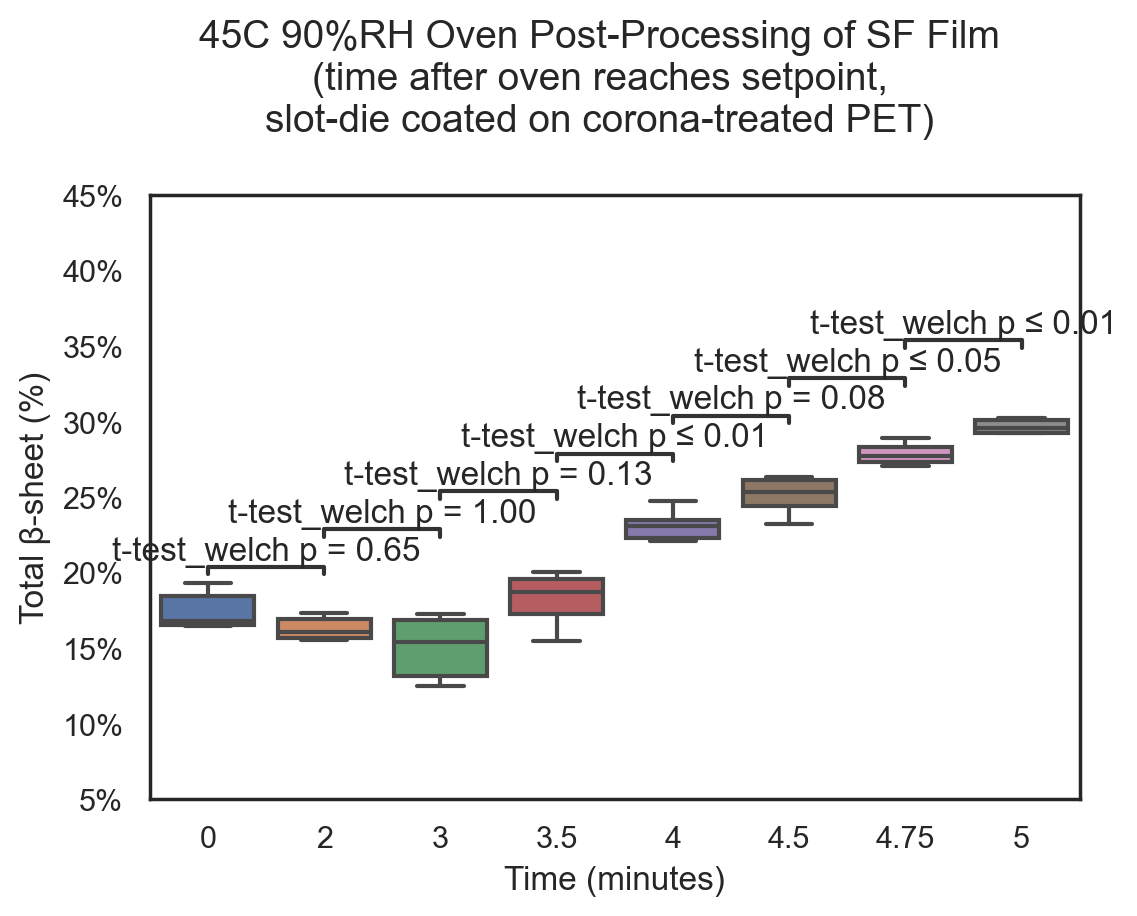

In [50]:
# annot.reset_configuration()
#add comparison between print layers and control to ensure no statistical differences
#should maybe make a df from this instead of my crap?
import string
import seaborn as sns
from scipy.stats import mannwhitneyu, normaltest
from utils import *


sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
sns.set_style("white")

from statannotations.Annotator import Annotator
import matplotlib.ticker as mtick
from matplotlib.offsetbox import AnchoredText
Tcleaned_secondarystructs_df = cleaned_secondarystructs_df.T

x= "minutes"
y= "Total β-sheet content"
order = ['0','2','3','3.5','4','4.5','4.75','5']
box_pairs = [('0','2'),('2','3'),('3','3.5'),('3.5','4'),('4','4.5'),('4.5','4.75'),('4.75','5')]

# formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

ax = sns.boxplot(data =Tcleaned_secondarystructs_df, x =x, y =y,color=None ,palette=None,linewidth=None, order = order)
annot = Annotator(ax,pairs = box_pairs, data =Tcleaned_secondarystructs_df, x=x, y =y, order=order)
annot.reset_configuration()
annot.configure(test='t-test_welch',loc='inside', verbose=2, show_test_name ='False' ,text_format="simple",comparisons_correction ='bonferroni',line_height=0.025, text_offset=.025)
# annot.configure(**{**configuration, "text_format":"simple", "text_offset":6})\
#     .apply_test().annotate()
# annot.set_custom_annotations(formatted_pvalues)
annot.apply_test()
ax,test_results = annot.annotate(line_offset_to_group=0.03, line_offset=0.03)
# StatsText = AnchoredText('test',loc='upper right', prop=dict(size=6), frameon=True)

plt.xlabel("Time (minutes)")
plt.ylabel("Total β-sheet (%)")
plt.suptitle('45C 90%RH Oven Post-Processing of SF Film'+ '\n'+'(time after oven reaches setpoint,'+'\n'+'slot-die coated on corona-treated PET)', fontsize=14, y=1.1, va='top')
#make y axis a percentage
plt.ylim(0.05, 0.45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1,decimals = 0))
plt.savefig(savefolderpath+'/'+'Box Plot.svg', format='svg')
plt.show()

In [ ]:
# import scipy.stats
# # F,p = scipy.stats.f_oneway(df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='37C WA']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='As Dried']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='MeOH Immersion']['total beta-sheet'])

# #ax.set_xlabel('200nm Spuncoat Film Treatment, n=3 per treatment' +'\n'+str(testresults))
# #ax.set_xlabel('Film Treatment, n=6 per treatment' +'\n'+"1-Way ANOVA P value:" + "{:.2e}".format(p))  #+ '\n' +"Groups compared with 1 way pairwise T-test with Bonferroni correction:"+
# # '\n'+  "37C WA vs As Dried:  \u03B1 0.05"+'\n'+"37C WA vs As Dried: asdf \u03B1 0.05"+'\n' +"37C WA vs As Dried: asdf \u03B1 0.05")
# # #ax.ylabel('%', fontweight ='bold', fontsize = 15)

# #ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

In [25]:
break_total_beta_percent

[array([0.33883764, 0.32595651, 0.32193627]),
 array([0.33863453, 0.33683692, 0.33975573]),
 array([0.33893088, 0.33720564, 0.33179342]),
 array([0.3286693 , 0.33842956, 0.33716471]),
 array([0.31603036, 0.32041664, 0.33499395]),
 array([0.28612361, 0.28388041, 0.31760052]),
 array([0.23531688, 0.23331312, 0.28880479])]

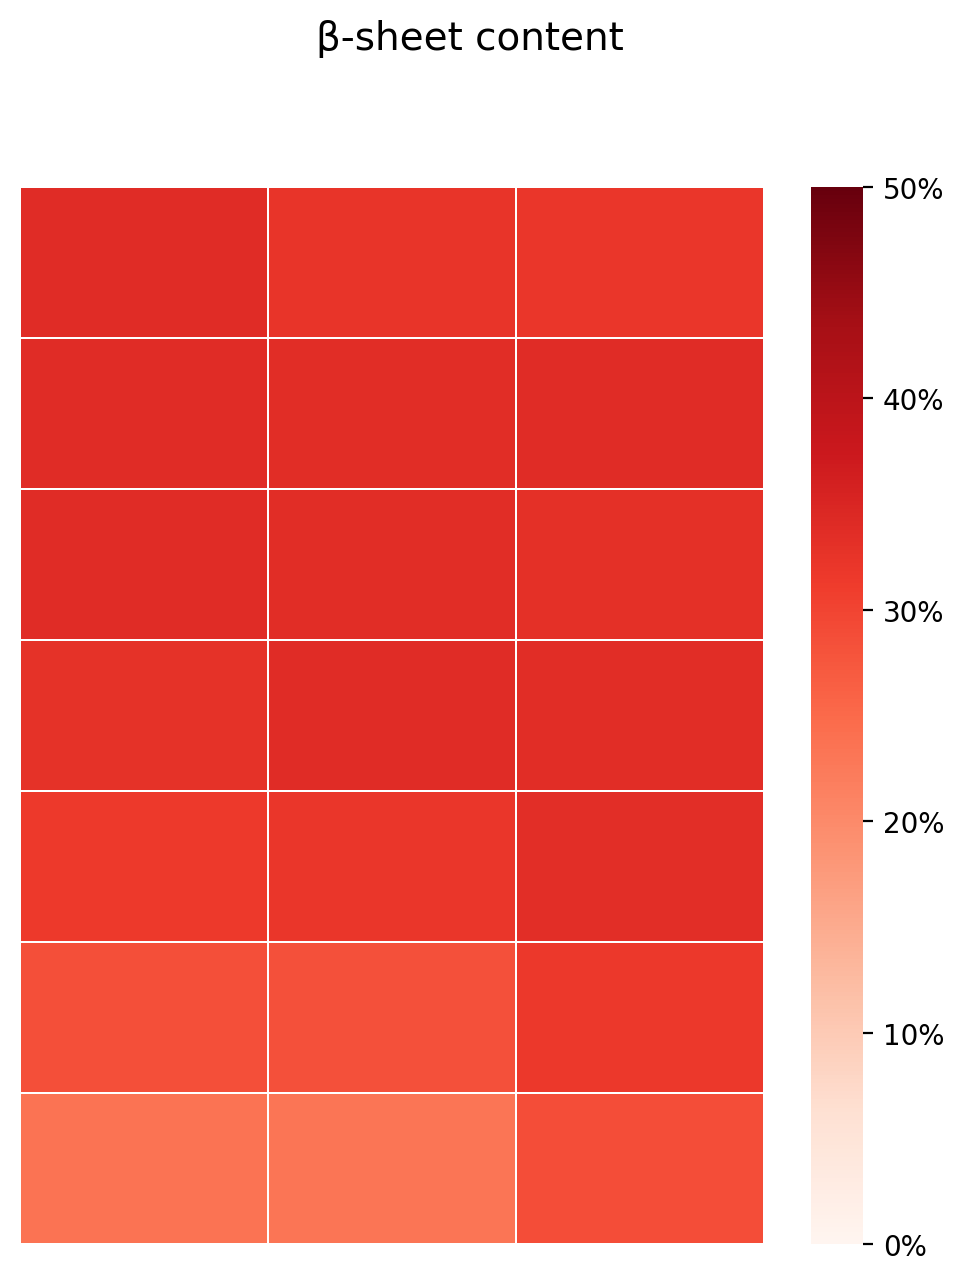

In [27]:
# heatmap via seaborn, plotted from 0 to 50% beta sheet content:
plt.figure(figsize=(num_in_x*2, num_in_y), dpi=200)

# save beta sheet content into csv; if from single microscopy file, use the shape of the data as it is; if it's from multiple files, save it with the header
fullcsvname = (savefolderpath+'/'+'Total_betasheet_Array.csv')
np.savetxt(fullcsvname, break_total_beta_percent, fmt='%.4f', delimiter=',')

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(
    num_in_y)], cmap="Reds", vmin=0, vmax=0.5, linewidths=.05, xticklabels=False, yticklabels=False)


plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0, 0.1, 0.2, 0.3, .4, .5])
cbar.set_ticklabels(['0%', '10%', '20%', '30%', '40%', '50%'])
plt.show()

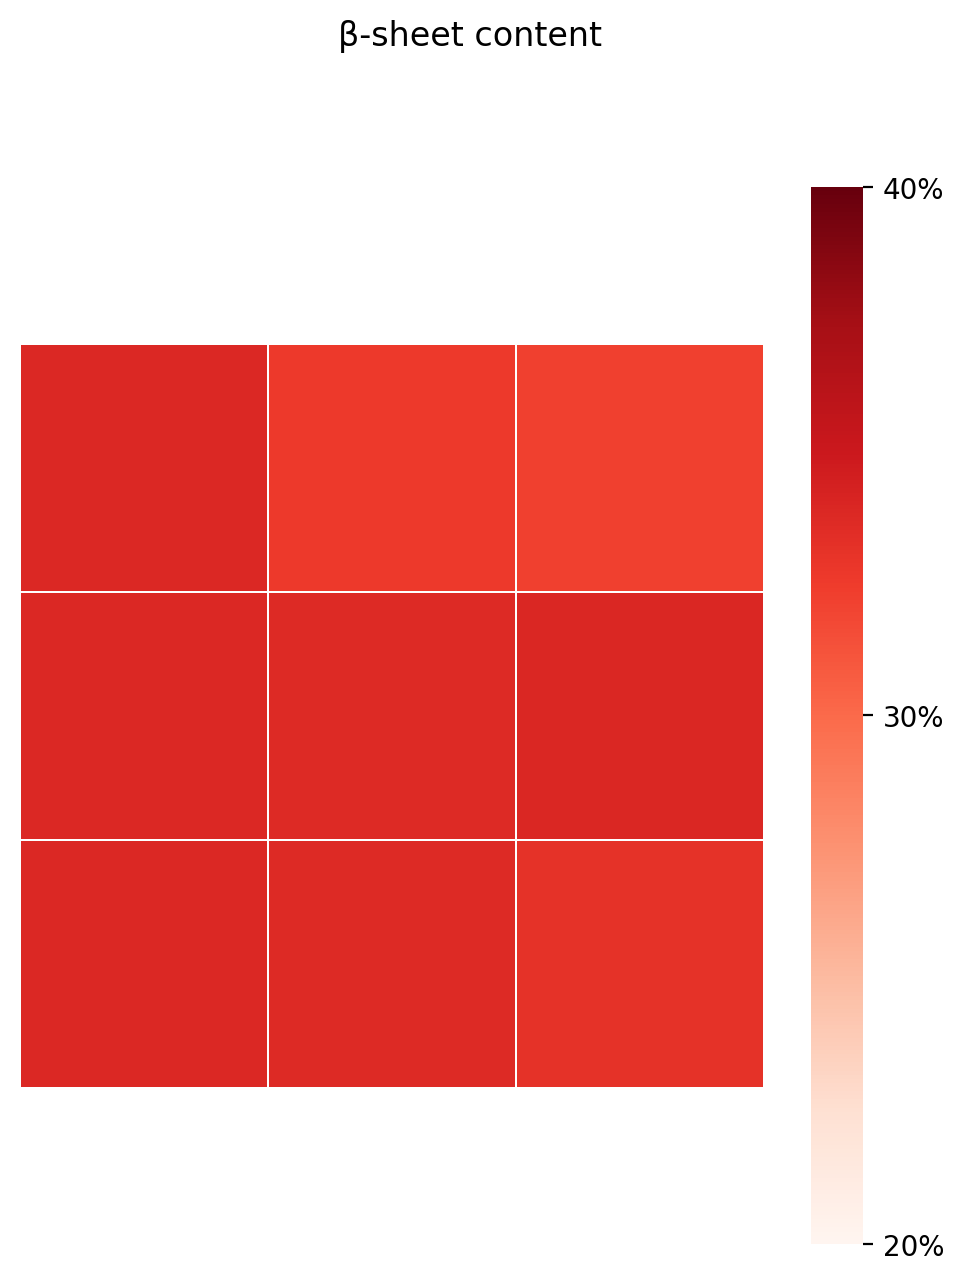

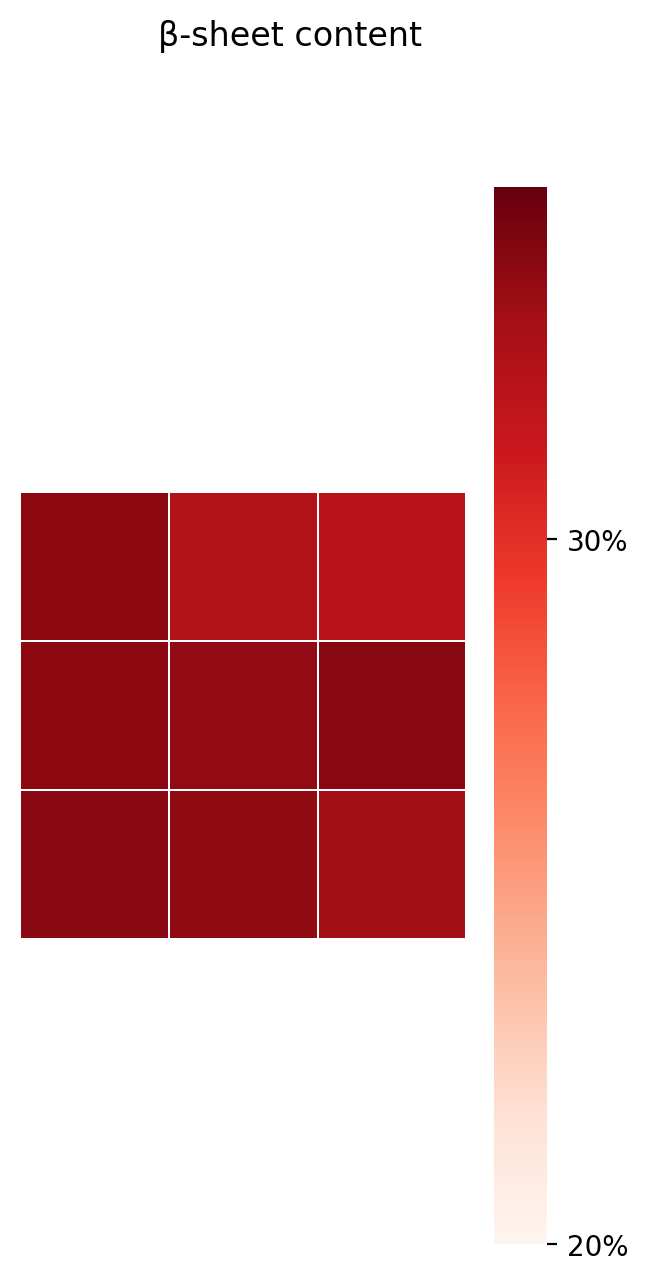

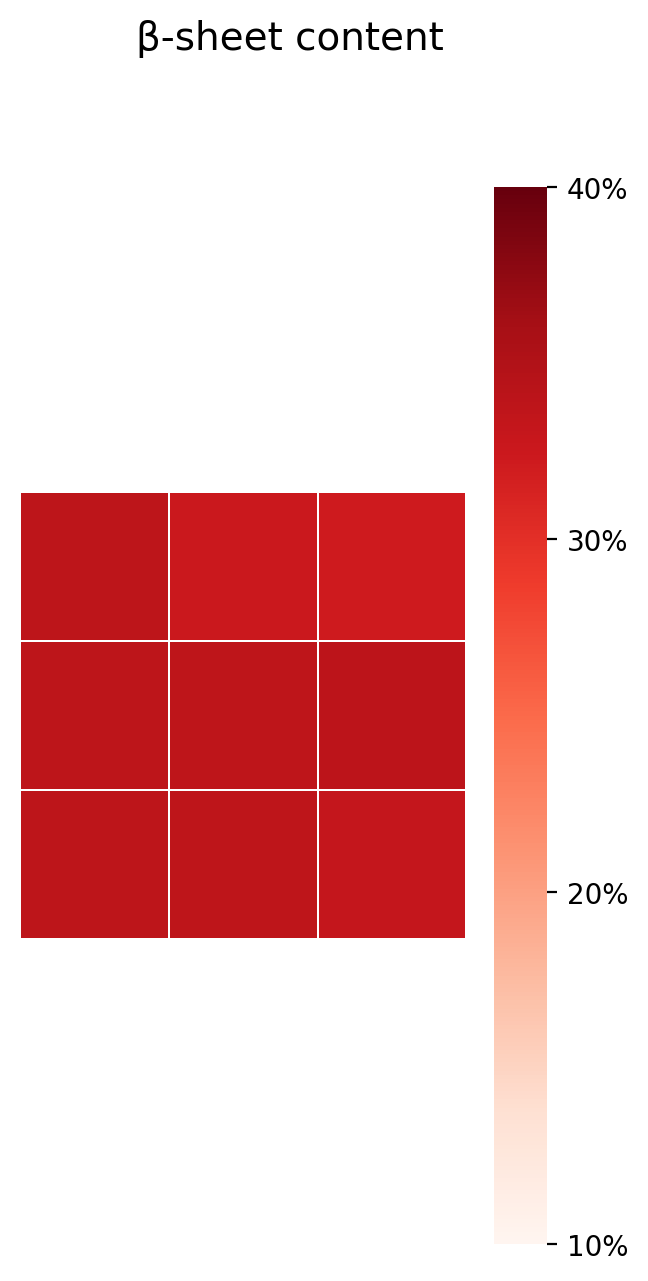

In [22]:
# heatmap via seaborn, plotted from 10 to 40% beta sheet content:
vmin = 0.1
vmax = 0.4

plt.figure(figsize=(num_in_x*1.2, num_in_y), dpi=200)

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds", vmin=vmin, vmax=vmax, linewidths=.05,
                         square=True, xticklabels=False, yticklabels=False)
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1, 0.2, 0.3, .4])
cbar.set_ticklabels(['10%', '20%', '30%', '40%'])

fullfigname = (savefolderpath+'/'+'HeatmapWhiteToRed10to40.png')
plt.savefig(fullfigname)
plt.show()

In [ ]:
# heatmap via seaborn, plotted from 10 to 50% beta sheet content blue to yellow to red:
plt.figure(figsize=(num_in_x*1.2, num_in_y), dpi=200)

hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="RdYlBu_r", vmin=0.10, vmax=0.5, linewidths=.05,
                         square=True, xticklabels=False, yticklabels=False)
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
plt.suptitle(hmtitletext, fontsize=14, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.2)
# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1, 0.2, 0.3, .4, .5])
cbar.set_ticklabels(['10%', '20%', '30%', '40%', '50%'])

fullfigname = (savefolderpath+'/'+'HeatmapBlueYellowRed10to50.png')
plt.savefig(fullfigname)


In [21]:
# Heatmap with GUI to input range of y bar and color option

# Jeff 3.20.2023

# Modified from https://www.geeksforgeeks.org/python-tkinter-entry-widget/

import math
root = tk.Tk()

# setting the windows size
root.geometry("450x150")
root.eval('tk::PlaceWindow . center')
root.wm_attributes('-topmost', True)
# root.lift()

# declaring numerical variables for storing x and y values
y_min = tk.IntVar()
y_max = tk.IntVar()
y_interval = tk.IntVar()

# defining a function that will get x and y values and close the window


def submit():
    global user_message_entry, num_y_min, num_y_max, num_y_interval
    # t = Toplevel(root)
    num_y_min = int(y_min.get())
    num_y_max = int(y_max.get())
    num_y_interval = int(y_interval.get())

    #print("Total number of spectra: " + str(num_in_x*num_in_y))
    time.sleep(0.5)
    root.destroy()


# creating a label for y_min using widget Label
y_min_label = tk.Label(
    root, text='Minimum beta-sheet value (in %): ', font=('calibre', 10, 'bold'))

# creating a entry for input of y_min using widget Entry
y_min_entry = tk.Entry(root, textvariable=y_min,
                       font=('calibre', 10, 'normal'))

# creating a label for y_max using widget Label
y_max_label = tk.Label(
    root, text='Maximum beta-Sheet Value (in %)  : ', font=('calibre', 10, 'bold'))

# creating a entry for y_max using widget Entry
y_max_entry = tk.Entry(root, textvariable=y_max,
                       font=('calibre', 10, 'normal'))

# creating a label for y_interval using widget Label
y_interval_label = tk.Label(
    root, text='Interval for Beta Sheet (in %, should be divisible ): ', font=('calibre', 10, 'bold'))

# creating a entry for y_interval using widget Entry
y_interval_entry = tk.Entry(
    root, textvariable=y_interval, font=('calibre', 10, 'normal'))

# creating a button using the widget button that will call the submit function
sub_btn = tk.Button(root, text='Submit', command=lambda: submit())

# placing the label and entry in the required position using grid method
y_min_label.grid(row=0, column=0)
y_min_entry.grid(row=0, column=1)
y_max_label.grid(row=1, column=0)
y_max_entry.grid(row=1, column=1)
y_interval_label.grid(row=2, column=0)
y_interval_entry.grid(row=2, column=1)
sub_btn.grid(row=3, column=1)

# performing an infinite loop for the window to display
root.mainloop()

# heatmap via seaborn with automatically changing intensity axis
plt.figure(figsize=(num_in_x*1.2, num_in_y), dpi=200)

# generate mininum and maximum values for colorscale by rounding to the nearest "10", then going down for min and up for max
vminimum = num_y_min/100  # math.floor(min(total_beta_percent)*10)/10
vmaximum = num_y_max/100  # math.ceil(max(total_beta_percent)*10)/10
vinterval = num_y_interval/100
hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds", vmin=vminimum, vmax=vmaximum, linewidths=.05,
                         xticklabels=False, yticklabels=False, square=True)
plt.suptitle(hmtitletext, fontsize=12, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.365)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
l = np.arange(vminimum, vmaximum+.1, 0.1)
print('l', l)
l1 = ["%.1f" % member for member in l*100]
print('l1', l1)
cbar.set_ticks(l)
l2 = ["%.0f" % member for member in l*100]
l3 = list(map("{}%".format, l2))
cbar.set_ticklabels(l3)

# save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapWhitetoRedCustomFitScalebar.png')
plt.savefig(fullfigname)

l [0.2 0.3 0.4]
l1 ['20.0', '30.0', '40.0']


In [20]:
# heatmap via seaborn with automatically changing intensity axis
import math
plt.figure(figsize=(num_in_x*2, num_in_y), dpi=200)

# generate mininum and maximum values for colorscale by rounding to the nearest "10", then going down for min and up for max
vminimum = math.floor(min(total_beta_percent)*10)/10
print('vmin', vminimum)
vmaximum = math.ceil(max(total_beta_percent)*10)/10
print('vmax', vmaximum)
hmtitletext = ('\u03B2-sheet content' + "\n")
ax_example = sns.heatmap(break_total_beta_percent[0:(num_in_x)], cmap="Reds", vmin=vminimum, vmax=vmaximum, linewidths=.05,
                         xticklabels=False, yticklabels=False, square=True)
plt.suptitle(hmtitletext, fontsize=12, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.365)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
l = np.arange(vminimum, vmaximum+.1, 0.1)
print('l', l)
l1 = ["%.1f" % member for member in l*100]
print('l1', l1)
cbar.set_ticks(l)
l2 = ["%.0f" % member for member in l*100]
l3 = list(map("{}%".format, l2))
cbar.set_ticklabels(l3)

# save heatmap into file
fullfigname = (savefolderpath+'/'+'HeatmapWhitetoRedAutoFitScalebar.png')
plt.savefig(fullfigname)

vmin 0.2
vmax 0.4
l [0.2 0.3 0.4]
l1 ['20.0', '30.0', '40.0']


In [ ]:
# heatmap via seaborn, plotted from 10 to 50% beta sheet content from white to red:
# (plot from CSV to fix bad scan values)


plt.figure(figsize=(num_in_x*2, num_in_y), dpi=200)

hmtitletext = ('\u03B2-sheet content' + "\n")

ax_example = sns.heatmap(data_from_csv, cmap="Reds", vmin=0.10, vmax=0.5, linewidths=.05,
                         square=True, xticklabels=False, yticklabels=False)
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
plt.suptitle(hmtitletext, fontsize=12, y=1, va='top')
fig.subplots_adjust(hspace=.2, wspace=.365)

# ax_example.invert_yaxis()
cbar = ax_example.collections[0].colorbar
cbar.set_ticks([0.1, 0.2, 0.3, .4, .5])
cbar.set_ticklabels(['10%', '20%', '30%', '40%', '50%'])

fullfigname = (savefolderpath+'/'+'CleanedHeatmapWhiteToRed10to50.png')
plt.savefig(fullfigname)


#Statistics (not finished so stop here)

In [ ]:
# crreate Mean,
total_beta_sheet_df['5min.0']

In [ ]:
# plot beta sheet concentration vs time
fig, ax = plt.subplots(figsize=(20, 10), constrained_layout=True)

titletext = ('\u03B2-sheet content vs Water Annealing Temperature and Time')
fig.suptitle(titletext, fontsize=16, y=1.05, va='top')
ax.plot(total_beta_sheet_df.columns, total_beta_percent, label='60C')

plt.show()


In [ ]:
# list_total_beta_sheet= []
# list_AHRC=[]
# list_beta_turn = []
# for i in range(len(structs)):
#     list_total_beta_sheet.append(structs[i]['aggregate \u03B2-strand/\u03B2-sheet']+structs[i]['intermolecular \u03B2-sheets (weak)'])
#     list_AHRC.append(structs[i]['random coils + \u03B1 helices'])
#     list_beta_turn.append(structs[i]['\u03B2-turns'])
# #list_total_beta_sheet[:]


# edge_list = ['MeOH No UV']*3
# inside_list = ['MeOH then 10hrUV']*3
# condition_list = [*edge_list,*inside_list]#inside_list.extend(outside_list)

# combinedConditionBetadict = {'Condition':condition_list,'total beta-sheet': list_total_beta_sheet}
# combinedConditionRCAHdict = {'Condition':condition_list,'random coil/alpha helix': list_AHRC}
# combinedConditionBetaTurndict = {'Condition':condition_list,'beta-turn': list_beta_turn}

# df_of_total_beta_sheet = pd.DataFrame(combinedConditionBetadict)
# df_of_AHRC = pd.DataFrame(combinedConditionRCAHdict)
# df_of_beta_turn = pd.DataFrame(combinedConditionBetaTurndict)
# #combinedConditionBetadict


In [ ]:
# # Make a paired t-test (or ANOVA 1 way + bonferonni correction plots for multiple comparisons) with p-value/significance displayed for total beta sheet
# import string
# import seaborn as sns
# sns.set(rc={"figure.dpi":200, 'savefig.dpi':200})
# sns.set_style("white")
# from statannot import add_stat_annotation
# import matplotlib.ticker as mtick

# order = ['MeOH No UV','MeOH then 10hrUV']
# box_pairs = [('MeOH No UV','MeOH then 10hrUV')]
# #beta sheet total
# ax = sns.boxplot(data =df_of_total_beta_sheet, x =df_of_total_beta_sheet['Condition'],
# y = df_of_total_beta_sheet["total beta-sheet"],order=order,color=None ,palette=None,linewidth=None)

# testresults = add_stat_annotation(ax, x = df_of_total_beta_sheet['Condition'],
# y = df_of_total_beta_sheet["total beta-sheet"],test='t-test_ind', text_format='star',
# loc='outside', verbose=2, box_pairs = box_pairs, comparisons_correction =None,
# order = order)

# StatsText = AnchoredText('test',loc='upper right', prop=dict(size=6), frameon=True)
# # ax.add_artist(StatsText)
# # Titletext  = ('p-value')
# # #plt.title('Mean WRFv3.5 LHF', fontsize=40)
# # fig.suptitle(titletext, fontsize=18,y=1.15, va='top')

# import scipy.stats
# # F,p = scipy.stats.f_oneway(df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='37C WA']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='As Dried']['total beta-sheet'],
# # df_of_total_beta_sheet[df_of_total_beta_sheet["Condition"]=='MeOH Immersion']['total beta-sheet'])

# #ax.set_xlabel('200nm Spuncoat Film Treatment, n=3 per treatment' +'\n'+str(testresults))
# #ax.set_xlabel('Film Treatment, n=6 per treatment' +'\n'+"1-Way ANOVA P value:" + "{:.2e}".format(p))  #+ '\n' +"Groups compared with 1 way pairwise T-test with Bonferroni correction:"+
# # '\n'+  "37C WA vs As Dried:  \u03B1 0.05"+'\n'+"37C WA vs As Dried: asdf \u03B1 0.05"+'\n' +"37C WA vs As Dried: asdf \u03B1 0.05")
# # #ax.ylabel('%', fontweight ='bold', fontsize = 15)

# ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
# plt.show()
# testresults
